# Dataset
https://huggingface.co/datasets/mystic-leung/medical_cord19

# Install Required Libraries &  Check GPU Availability

In [ ]:
!pip install "transformers[sentencepiece]" datasets sacrebleu rouge_score py7zr -q
!nvidia-smi
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
!pip install evaluate

In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.1 MB/s eta 0:00:00


# Import Libraries

In [ ]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from evaluate import load as load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load Pre-trained PEGASUS Model and Tokenizer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

# Define Helper Functions for Data Processing and Evaluation

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="input",
                               column_summary="output"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the <pad> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("<pad>", " ") for d in decoded_summaries]

        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

# Load and Prepare the Dataset
Dataset Link: https://huggingface.co/datasets/mystic-leung/medical_cord19

In [ ]:
dataset_name = "mystic-leung/medical_cord19"
data= load_dataset(dataset_name,split='train')
num_samples = 500
dataset_samsum = data.select(range(num_samples)).train_test_split(test_size=0.2)

README.md:   0%|          | 0.00/194 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/331M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/70.8M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/70.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/210000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/45000 [00:00<?, ? examples/s]

In [ ]:
print(f"Features: {dataset_samsum['train'].column_names}")

Features: ['input', 'output']


# Load Evaluation Metric (ROUGE)

In [ ]:
rouge_metric = load_metric('rouge')

# Evaluate the Pre-trained Model on the Test Set

In [ ]:
score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text='input', column_summary='output', batch_size=8)

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

# Displaying the scores
pd.DataFrame(rouge_dict, index=['pegasus'])

100%|██████████| 13/13 [02:35<00:00, 11.93s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.238985,0.104768,0.185111,0.184566


# Generate and Print a Summary Using the Pipeline

In [ ]:
dataset_samsum['test'][1]['input']

pipe = pipeline('summarization', model=model_ckpt)

pipe_out = pipe(dataset_samsum['test'][1]['input'])

print(pipe_out)

print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'summary_text': 'Overcrowding in the emergency department (ED) can occur because of the volume of patients waiting to be seen .<n>During the pandemic, ED crowding increased dramatically, although the overall number of patients decreased .<n>Access Block solutions are required to prevent a recurrence of crowding to any new viral wave or new epidemic in the future .'}]
Overcrowding in the emergency department (ED) can occur because of the volume of patients waiting to be seen.
During the pandemic, ED crowding increased dramatically, although the overall number of patients decreased.
Access Block solutions are required to prevent a recurrence of crowding to any new viral wave or new epidemic in the future .


# Visualize Token Length Distributions

Token indices sequence length is longer than the specified maximum sequence length for this model (1070 > 1024). Running this sequence through the model will result in indexing errors


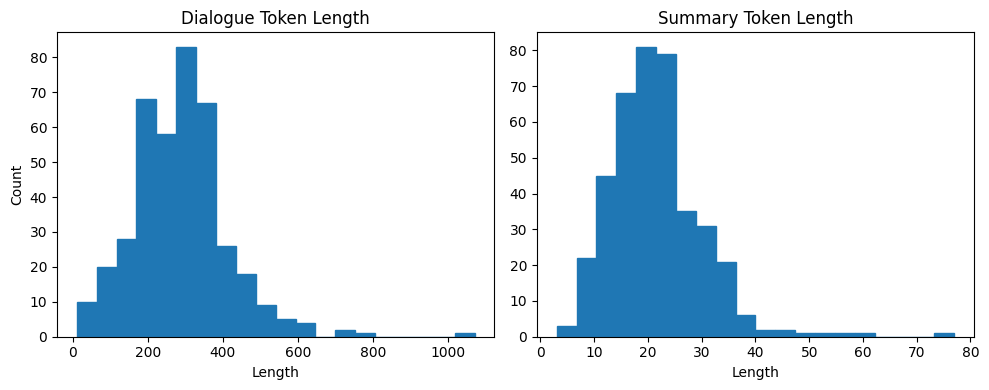

In [ ]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['input']]
summary_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['output']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# Prepare the Dataset for Training

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['input'], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['output'], max_length=128, truncation=True)

    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Set Up Data Collator for Sequence-to-Sequence Tasks

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

# Enable Gradient Checkpointing and Adjust Tokenizer

In [ ]:
model_pegasus.gradient_checkpointing_enable()
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512)

# Configure and Initialize the Trainer for Model Training

In [ ]:
from transformers import Trainer, TrainingArguments
from accelerate import Accelerator


accelerator = Accelerator()

train_dataset = dataset_samsum_pt['train']
eval_dataset = dataset_samsum_pt['test']

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16,
    report_to='none'
)

trainer = Trainer(
    model=model_pegasus,
    args=trainer_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-82a927b70f2b>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train the Model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=25, training_loss=4.371395111083984, metrics={'train_runtime': 279.996, 'train_samples_per_second': 1.429, 'train_steps_per_second': 0.089, 'total_flos': 323092348526592.0, 'train_loss': 4.371395111083984, 'epoch': 1.0})

# Re-evaluate the Fine-tuned Model on the Test Set

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size=2, column_text='input', column_summary='output'
)

rouge_dict = {rn: score[rn] for rn in rouge_names}
rouge_df = pd.DataFrame(rouge_dict, index=["pegasus"])
print(rouge_df)

100%|██████████| 50/50 [03:38<00:00,  4.37s/it]


           rouge1    rouge2    rougeL  rougeLsum
pegasus  0.225052  0.090024  0.181915   0.181877


# Save the Fine-tuned Model and Tokenizer

In [ ]:
model_pegasus.save_pretrained("pegasus-samsum-model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Generate and Compare a Sample Summary

In [ ]:
sample_text = dataset_samsum["test"][0]["input"]
reference = dataset_samsum["test"][0]["output"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
pipe = pipeline("summarization", model="pegasus-samsum-model", tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
OBJECTIVE: This exploratory study estimates the economic value of the current vaccination program and increased coverage against four preventable diseases in older adults in the United States (US). METHODS: A population-based, age-structured economic model was used to conduct a cost-benefit analysis of vaccination against influenza, pertussis, herpes zoster, and pneumococcal disease among US adults aged 50 years and older, accounting for aging of the population. The model used separate decision trees for each disease to project the discounted number of vaccinated individuals, number of disease cases, and direct medical and indirect costs (2018 US$) over a 30-year period. Benefit-cost ratios (BCRs) and net present values were calculated for two primary analyses comparing current vaccination coverage versus no vaccination and comparing increased coverage versus current coverage. Key parameter values were varied in deterministic sensitivity analyses. RESULTS: Current adult vacci